# Sistema de Reconhecimento Facial

## 1. Montar Google Drive

In [ ]:
# ======================================================
# 1. Montar Google Drive
# ======================================================
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive")

# Definir caminho da pasta já combinada
combined = Path("/content/drive/MyDrive/facescrub_selected")
assert combined.exists(), "❌ Pasta /content/drive/MyDrive/facescrub_selected não encontrada!"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Selecionar classes

In [ ]:
# ======================================================
# 2. Selecionar classes (limitando a N_CLASSES)
# ======================================================
from collections import Counter

class_counts = Counter({
    p.name: len(list(p.glob("*.jpg"))) +
            len(list(p.glob("*.jpeg"))) +
            len(list(p.glob("*.png")))
    for p in combined.iterdir() if p.is_dir()
})

N_CLASSES = 10  # número de classes a usar
top_classes = [cls for cls, _ in class_counts.most_common(N_CLASSES)]

print(f"📊 Selecionadas {len(top_classes)} classes:")
for cls in top_classes:
    print(f" - {cls}: {class_counts[cls]} imagens")



📊 Selecionadas 10 classes:
 - Kristin_Chenoweth: 148 imagens
 - America_Ferrera: 146 imagens
 - Gabriel_Macht: 140 imagens
 - Felicity_Huffman: 136 imagens
 - Holly_Marie_Combs: 133 imagens
 - Fran_Drescher: 132 imagens
 - Geena_Davis: 131 imagens
 - Debra_Messing: 130 imagens
 - Courteney_Cox: 128 imagens
 - Julie_Benz: 128 imagens


## 3. Geradores de treino/validação

In [ ]:
# ======================================================
# 3. Geradores de treino/validação
# ======================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    combined,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=top_classes,
    subset='training'
)

val_gen = test_datagen.flow_from_directory(
    combined,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=top_classes,
    subset='validation'
)




Found 1086 images belonging to 10 classes.
Found 267 images belonging to 10 classes.


## 4. Modelo baseado em MobileNetV2

In [ ]:
# ======================================================
# 4. Modelo baseado em MobileNetV2
# ======================================================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=IMG_SIZE+(3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(top_classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Treinamento

In [ ]:
# ======================================================
# 5. Treinamento com EarlyStopping
# ======================================================
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 454s 13s/step - accuracy: 0.1683 - loss: 2.4602 - val_accuracy: 0.3633 - val_loss: 1.7744
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step - accuracy: 0.4504 - loss: 1.6145 - val_accuracy: 0.5281 - val_loss: 1.3834
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.5374 - loss: 1.3797 - val_accuracy: 0.6067 - val_loss: 1.1584
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.6089 - loss: 1.1699 - val_accuracy: 0.6442 - val_loss: 1.0422
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step - accuracy: 0.6565 - loss: 1.0001 - val_accuracy: 0.6292 - val_loss: 0.9875
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.6926 - loss: 0.9452 - val_accuracy: 0.7378 - val_loss: 0.8389
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.6987 - loss: 0.8684 - val_accuracy: 0.7116 - val_loss: 0.8361
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - accuracy: 0.7086 - loss: 0.8148 - val_accur

## 6. Avaliação

In [ ]:
# ======================================================
# 6. Avaliação no conjunto de validação
# ======================================================
val_loss, val_acc = model.evaluate(val_gen)
print(f"✅ Validação - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7576 - loss: 0.6684
✅ Validação - Loss: 0.6294, Accuracy: 0.7940


## 7. Teste de Predição

Saving gabriel.jpg to gabriel.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

🔎 Top-5 predições:
 - Gabriel_Macht: 0.89
 - Geena_Davis: 0.03
 - Kristin_Chenoweth: 0.03
 - Holly_Marie_Combs: 0.03
 - Debra_Messing: 0.01


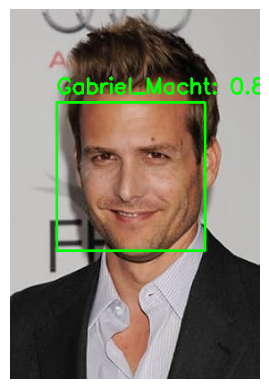

In [ ]:

# ======================================================
# 7. Predição em imagem externa com bounding box + top-5
# ======================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

# Haarcascade para detecção de faces
cv2_base_dir = cv2.__file__.rsplit('/', 1)[0]
haar_model = cv2_base_dir + "/data/haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_model)

def predict_external_image(filepath):
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        print("❌ Nenhum rosto detectado!")
        return

    for (x, y, w, h) in faces:
        face_img = img[y:y+h, x:x+w]
        face_resized = cv2.resize(face_img, IMG_SIZE)
        face_array = np.expand_dims(face_resized/255.0, axis=0)

        preds = model.predict(face_array)[0]
        top5_idx = preds.argsort()[-5:][::-1]

        print("\n🔎 Top-5 predições:")
        for i in top5_idx:
            print(f" - {top_classes[i]}: {preds[i]:.2f}")

        best_class = top_classes[np.argmax(preds)]
        conf = np.max(preds)

        label = f"{best_class}: {conf:.2f}"
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Upload e teste
uploaded = files.upload()
for fn in uploaded.keys():
    predict_external_image(fn)